# MindSpore实战二，CIFAR-10图像分类

数据集介绍：
* CIFAR-10数据集由10个类的60000个32x32彩色图像组成，每个类有6000个图像。有50000个训练图像和10000个测试图像。数据集分为五个训练批次和一个测试批次，每个批次有10000个图像。测试批次包含来自每个类别的恰好1000个随机选择的图像。训练批次以随机的顺序输入图像，但一些训练批次可能包含来自一个类别的图像比另一个更多。总体来说，五个训练集之和包含来自每个类的正好5000张图像。
* 10个类完全相互排斥，且类之间没有重叠，汽车和卡车之间没有重叠。“汽车”包括轿车，SUV等。“卡车”只包括大卡车，不包括皮卡车。
* CIFAR-10数据集官网：https://www.cs.toronto.edu/~kriz/cifar.html

<img src="image/01.png">

本实验使用MindSpore深度学习框架，演示一个完整的图像分类模型开发流程。

实验流程（新增数据展示、模型优化、模型重训练预评估）：

<img src="image/02.png">

注意：
1. 请确保存储路径只有英文，否则可能报错。
2. 第二次运行请先清空results文件夹，否则可能报错。

## 环境准备
* Mindspore模块主要用于本次实验卷积神经网络的构建，包括很多子模块。
    * mindspore.dataset：包括CIFAR-10数据集的载入与处理，也可以自定义数据集。

    * mindspore.common：包中会有诸如type形态转变、权重初始化等的常规工具。

    * mindspore.nn：主要包括网络可能涉及到的各类网络层，诸如卷积层、池化层、全连接层，也包括损失函数，激活函数等。
    
    * mindspore.train.callback：涉及到各类回调函数，如checkpoint，lossMonitor等，也可以自定义Callback。
    
    * context：设定mindspore的运行环境与运行设备。
    
    * Model：承载网络结构，并能够调用优化器、损失函数、评价指标。
    
    * save_checkpoint, load_checkpoint：保存与读取最佳网络参数。

本实验需要以下第三方库：
1. MindSpore 1.7
2. Numpy 1.17.5
3. matplotlib 3.3.4

Python 环境导入

In [1]:
import mindspore

# mindspore.dataset
import mindspore.dataset as ds # 数据集的载入
import mindspore.dataset.transforms.c_transforms as C # 常用转化算子
import mindspore.dataset.vision.c_transforms as CV # 图像转化算子

# mindspore.common
from mindspore.common import dtype as mstype # 数据形态转换
from mindspore.common.initializer import Normal # 参数初始化

# mindspore.nn
import mindspore.nn as nn # 各类网络层都在nn里面
from mindspore.nn.metrics import Accuracy, Loss # 测试模型用

# mindspore.train.callback
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor, Callback # 回调函数


from mindspore import Model # 承载网络结构
from mindspore import save_checkpoint, load_checkpoint # 保存与读取最佳参数
from mindspore import context # 设置mindspore运行的环境


import numpy as np # numpy
import matplotlib.pyplot as plt # 可视化用
import copy # 保存网络参数用

# 数据路径处理
import os, stat

MindSpore 环境设置

MindSpore支持两种运行模式，在调试或者运行方面做了不同的优化：
* PYNATIVE模式：也称动态图模式，将神经网络中的各个算子逐一下发执行，方便用户编写和调试神经网络模型。
* GRAPH模式：也称静态图模式或者图模式，将神经网络模型编译成一整张图，然后下发执行。该模式利用图优化等技术提高运行性能，同时有助于规模部署和跨平台运行。

In [2]:
device_target = context.get_context('device_target') # 获取运行装置（CPU，GPU，Ascend）
dataset_sink_mode = True if device_target in ['Ascend','GPU'] else False # 是否将数据通过pipeline下发到装置上
context.set_context(mode = context.GRAPH_MODE, device_target = device_target) # 设置运行环境，静态图context.GRAPH_MODE指向静态图模型，即在运行之前会把全部图建立编译完毕

print(f'device_target: {device_target}')
print(f'dataset_sink_mode: {dataset_sink_mode}')

device_target: CPU
dataset_sink_mode: False


## 数据展示
查看数据集

In [3]:
# 数据路径
train_path = os.path.join('cifar-10-batches-bin') # 训练集路径
test_path = os.path.join('cifar-10-verify-bin') # 测试集路径
print(f'训练集路径：{train_path}')
print(f'测试集路径：{test_path}')

训练集路径：cifar-10-batches-bin
测试集路径：cifar-10-verify-bin


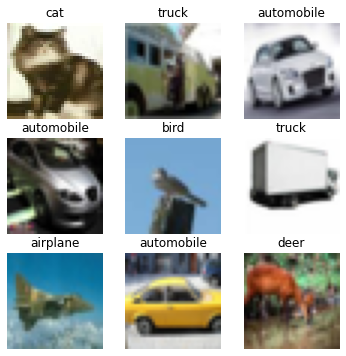

In [4]:
# 创建图像标签列表
category_dict = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',
                 6:'frog',7:'horse',8:'ship',9:'truck'}

# 载入展示用数据
demo_data = ds.Cifar10Dataset(test_path)

# 设置图像大小
plt.figure(figsize=(6, 6))

# 打印9张子图
i = 1
for dic in demo_data.create_dict_iterator():
    plt.subplot(3,3,i)
    plt.imshow(dic['image'].asnumpy()) # asnumpy：将 MindSpore tensor 转换成 numpy
    plt.axis('off')
    plt.title(category_dict[dic['label'].asnumpy().item()])
    i +=1
    if i > 9 :
        break

plt.show()

## 数据处理

计算数据集平均数和标准差，数据标准化时使用

In [5]:
ds_train = ds.Cifar10Dataset(train_path)
#计算数据集平均数和标准差，数据标准化时使用
tmp = np.asarray( [x['image'] for x in ds_train.create_dict_iterator(output_numpy=True)] )
RGB_mean = tuple(np.mean(tmp, axis=(0, 1, 2)))
RGB_std = tuple(np.std(tmp, axis=(0, 1, 2)))

print(RGB_mean)
print(RGB_std)

(125.306918046875, 122.950394140625, 113.86538318359375)
(62.99321927773514, 62.08870764038018, 66.70489964064973)


定义数据预处理函数

函数功能包括：
1. 加载数据集
1. 打乱数据集
1. 图像特征处理（包括尺寸大小变更、平移、标准化、训练时的随机裁剪、随机翻转等）
3. 批量输出数据
4. 重复

In [6]:
def create_dataset(data_path, batch_size = 32, repeat_num=1, usage = 'train'):
    """ 
    数据处理
    
    Args:
        data_path (str): 数据路径
        batch_size (int): 批量大小
        usage (str): 训练或测试
        
    Returns:
        Dataset对象
    """
    
    # 载入数据集
    data = ds.Cifar10Dataset(data_path)
    
    # 打乱数据集
    data = data.shuffle(buffer_size=10000)
    
    # 定义算子
    if usage=='train':
        trans = [
            CV.Normalize(RGB_mean, RGB_std), # 数据标准化

            # 数据增强
            CV.RandomCrop([32, 32], [4, 4, 4, 4]), # 随机裁剪
            CV.RandomHorizontalFlip(), # 随机翻转

            CV.HWC2CHW() # 通道前移（为配适网络，CHW的格式可最佳发挥昇腾芯片算力）
        ]
    else:
        trans = [
            CV.Normalize(RGB_mean, RGB_std), # 数据标准化
            CV.HWC2CHW() # 通道前移（为配适网络，CHW的格式可最佳发挥昇腾芯片算力）
        ]
    
    typecast_op = C.TypeCast(mstype.int32) # 原始数据的标签是unint，计算损失需要int

    # 算子运算
    data = data.map(input_columns='label', operations=typecast_op)
    data = data.map(input_columns='image', operations=trans)
    
    # 批处理
    data = data.batch(batch_size, drop_remainder=True)
    
    # 重复
    data = data.repeat(repeat_num)
    
    return data

## 网络定义

使用“MindSpore实战一”中介绍的网络，LeNet5

In [7]:
class LeNet5(nn.Cell):
    """
    LeNet5网络

    Args:
        num_class (int): 输出分类数
        num_channel (int): 输入通道数
    Returns:
        Tensor, 输出张量

    Examples:
        >>> LeNet5(10, 3)
    """
    
    # 定义算子
    def __init__(self, num_class=10, num_channel=3):
        super(LeNet5, self).__init__()
        # 卷积层
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        
        # 全连接层
        self.fc1 = nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        
        # 激活函数
        self.relu = nn.ReLU()
        
        # 最大池化成
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 网络展开
        self.flatten = nn.Flatten()

    # 建构网络
    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

## 模型训练

载入数据

In [8]:
train_data = create_dataset(train_path, batch_size = 32, usage = 'train') # 训练数据集
test_data = create_dataset(test_path, batch_size = 50, usage= 'test') # 测试数据集

构建网络、损失函数、优化器、模型

In [9]:
# 网络
network1 = LeNet5(10)

# 损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 优化器
net_opt = nn.Momentum(params=network1.trainable_params(), learning_rate=0.01, momentum=0.9)

# 模型
model = Model(network = network1, loss_fn=net_loss, optimizer=net_opt, metrics={'accuracy': Accuracy(), 'loss':Loss()})

定义记录loss的Callback，每个epoch结束时记录

Callback介绍：
https://www.mindspore.cn/docs/zh-CN/r1.7/api_python/mindspore.train.html#mindspore.train.callback.Callback

自定义Callback教程：https://www.mindspore.cn/tutorials/zh-CN/r1.7/advanced/train/callback.html

In [10]:
# 记录模型每个epoch的loss
class TrainHistroy(Callback):
    """
    记录模型训练时每个epoch的loss的回调函数

    Args:
        history (list): 传入list以保存模型每个epoch的loss
    """
    
    def __init__(self, history):
        super(TrainHistroy, self).__init__()
        self.history = history
        
    # 每个epoch结束时执行
    def epoch_end(self, run_context):
        cb_params = run_context.original_args()
        loss = cb_params.net_outputs.asnumpy()
        self.history.append(loss)
        

# 测试并记录模型在测试集的loss和accuracy，每个epoch结束时进行模型测试并记录结果，跟踪并保存准确率最高的模型网络参数
class EvalHistory(Callback):
    """
    记录模型训练时每个epoch在测试集的loss和accuracy的回调函数，并保存准确率最高的模型网络参数

    Args:
        model (Cell): 模型，评估loss和accuracy用
        loss_history (list): 传入list以保存模型每个epoch在测试集的loss
        acc_history (list): 传入list以保存模型每个epoch在测试集的accuracy
        eval_data (Dataset): 测试集，评估模型loss和accuracy用
    """
    
    #保存accuracy最高的网络参数
    best_param = None
    
    def __init__(self, model, loss_history, acc_history, eval_data):
        super(EvalHistory, self).__init__()
        self.loss_history = loss_history
        self.acc_history = acc_history
        self.eval_data = eval_data
        self.model = model
    
    # 每个epoch结束时执行
    def epoch_end(self, run_context):
        cb_params = run_context.original_args()
        res = self.model.eval(self.eval_data, dataset_sink_mode=False)
        
        if len(self.acc_history)==0 or res['accuracy']>=max(self.acc_history):
            self.best_param = copy.deepcopy(cb_params.network)
            
        self.loss_history.append(res['loss'])
        self.acc_history.append(res['accuracy'])
        
        print('acc_eval: ',res['accuracy'])
    
    # 训练结束后执行
    def end(self, run_context):
        # 保存最优网络参数
        best_param_path = os.path.join(ckpt_path, 'best_param.ckpt')
        
        if os.path.exists(best_param_path):
            # best_param.ckpt已存在时MindSpore会覆盖旧的文件，这里修改文件读写权限防止报错
            os.chmod(best_param_path, stat.S_IWRITE)
            
        save_checkpoint(self.best_param, best_param_path)

设置回调函数（Callback）

In [11]:
ckpt_path = os.path.join('.','results') # 网络参数保存路径
hist = {'loss':[], 'loss_eval':[], 'acc_eval':[]} # 训练过程记录

# 网络参数自动保存，这里设定每2000个step保存一次，最多保存10次
config_ck = CheckpointConfig(save_checkpoint_steps=2000,
                             keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix='checkpoint_lenet', directory=ckpt_path, config=config_ck)

# 监控每次迭代的时间
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())

# 监控loss值
loss_cb = LossMonitor(per_print_times=500)

# 记录每次迭代的模型损失值
train_hist_cb = TrainHistroy(hist['loss'])

# 测试并记录模型在验证集的loss和accuracy，并保存最优网络参数
eval_hist_cb = EvalHistory(model = model,
                           loss_history = hist['loss_eval'], 
                           acc_history = hist['acc_eval'], 
                           eval_data = test_data)

训练模型

In [12]:
epoch = 10 # 迭代次数
# 开始训练
model.train(epoch, train_data, callbacks=[train_hist_cb, eval_hist_cb, time_cb, ckpoint_cb, loss_cb], dataset_sink_mode=dataset_sink_mode)

epoch: 1 step: 500, loss is 2.294740915298462
epoch: 1 step: 1000, loss is 2.2863516807556152
epoch: 1 step: 1500, loss is 1.9555445909500122
acc_eval:  0.2759
epoch time: 13250.185 ms, per step time: 8.483 ms
epoch: 2 step: 438, loss is 1.9577600955963135
epoch: 2 step: 938, loss is 1.5748080015182495
epoch: 2 step: 1438, loss is 1.7610833644866943
acc_eval:  0.4618
epoch time: 11814.837 ms, per step time: 7.564 ms
epoch: 3 step: 376, loss is 1.7368584871292114
epoch: 3 step: 876, loss is 1.6689149141311646
epoch: 3 step: 1376, loss is 1.664615511894226
acc_eval:  0.4991
epoch time: 13221.693 ms, per step time: 8.465 ms
epoch: 4 step: 314, loss is 1.3312057256698608
epoch: 4 step: 814, loss is 1.241560935974121
epoch: 4 step: 1314, loss is 1.6161003112792969
acc_eval:  0.5229
epoch time: 13563.937 ms, per step time: 8.684 ms
epoch: 5 step: 252, loss is 1.080346703529358
epoch: 5 step: 752, loss is 1.2767258882522583
epoch: 5 step: 1252, loss is 1.6718626022338867
acc_eval:  0.5271
epo

## 模型评估
注意：测试集不会进行随机裁剪与翻转。

观察模型loss的变化

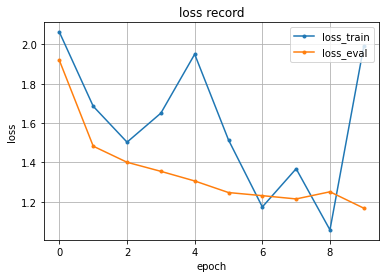

In [13]:
# 定义loss记录绘制函数
def plot_loss(hist):
    plt.plot(hist['loss'], marker='.')
    plt.plot(hist['loss_eval'], marker='.')
    plt.title('loss record')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend(['loss_train', 'loss_eval'], loc='upper right')
    plt.show()
    plt.close()

plot_loss(hist)

观察模型accuracy变化

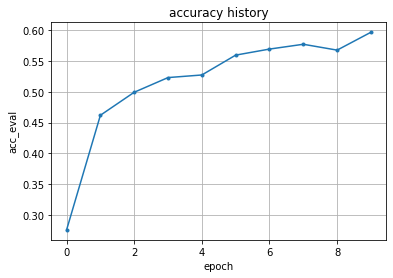

In [14]:
def plot_accuracy(hist):
    plt.plot(hist['acc_eval'], marker='.')
    plt.title('accuracy history')
    plt.xlabel('epoch')
    plt.ylabel('acc_eval')
    plt.grid()
    plt.show()
    plt.close()

plot_accuracy(hist)

载入最佳网络参数，并测试其accuracy与loss

In [15]:
# 使用准确率最高的参数组合建立模型，并测试其在验证集上的效果
load_checkpoint(os.path.join(ckpt_path, 'best_param.ckpt'), net=network1)
res = model.eval(test_data, dataset_sink_mode=dataset_sink_mode)
print(res)

{'accuracy': 0.5964, 'loss': 1.167859348356724}


## 模型优化
Lenet网络本身的复杂度并不足以对CIFAR-10的图像分类任务产生出足够的拟合效果，因此需要做进一步改进。总的来说，网络基本维持了lenet的网络结构，增加卷积的个数与卷积核的大小，同时略微增加了网络的深度。
1.	所有的卷积核从5∗5变成3∗3。
2.	增加了一层网络的深度，提升模型的非线性映射能力。
3.	提升了卷积核数量，使模型可以提取更多的特征，如32核，64核，128核。

In [16]:
class LeNet5_2(nn.Cell):
    
    # 定义算子
    def __init__(self, num_class=10, num_channel=3):
        super(LeNet5_2, self).__init__()
        self.conv1 = nn.Conv2d(num_channel, 32, 3, pad_mode='valid', weight_init=Normal(0.02))
        self.conv2 = nn.Conv2d(32, 64, 3, pad_mode='valid', weight_init=Normal(0.02))
        self.conv3 = nn.Conv2d(64, 128, 3, pad_mode='valid', weight_init=Normal(0.02))
        self.fc1 = nn.Dense(128 * 2 * 2, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.num_class = num_class
    
    # 构建网络
    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

数据预处理不做调整，重新创建训练集合测试集。

In [17]:
# 训练数据集预处理
train_data = create_dataset(train_path, batch_size = 32, usage = 'train')
# 测试数据集预处理
test_data = create_dataset(test_path, batch_size = 50, usage = 'test')

构建新的网络、损失函数、优化器、模型

In [18]:
# 网络
network2 = LeNet5_2(10)

# 损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 优化器
net_opt = nn.Adam(params=network2.trainable_params())

# 模型
model = Model(network = network2, loss_fn=net_loss, optimizer=net_opt, metrics={'accuracy': Accuracy(), 'loss':Loss()})

定义新的Callback

In [19]:
hist = {'loss':[], 'loss_eval':[], 'acc_eval':[]} # 训练过程记录

# 网络参数自动保存，这里设定每2000个step保存一次，最多保存10次
config_ck = CheckpointConfig(save_checkpoint_steps=2000, keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix='checkpoint_lenet_2', directory=ckpt_path, config=config_ck)

# 记录每次迭代的模型准确率
train_hist_cb = TrainHistroy(hist['loss'])

# 测试并记录模型在验证集的loss和accuracy，并保存最优网络参数
eval_hist_cb = EvalHistory(model = model,
                           loss_history = hist['loss_eval'], 
                           acc_history = hist['acc_eval'], 
                           eval_data = test_data)

## 重新训练与评估
优化了模型的网络结构并改用Adam优化器，数据预处理、模型训练的超参数与损失函数没做调整。

In [20]:
epoch = 10 # 迭代次数
# 开始训练
model.train(epoch, train_data, 
            callbacks=[train_hist_cb, eval_hist_cb, time_cb, ckpoint_cb, LossMonitor(per_print_times=500)], 
            dataset_sink_mode=dataset_sink_mode)

epoch: 1 step: 500, loss is 1.675309658050537
epoch: 1 step: 1000, loss is 1.5961780548095703
epoch: 1 step: 1500, loss is 1.562337875366211
acc_eval:  0.4739
epoch time: 26604.937 ms, per step time: 17.033 ms
epoch: 2 step: 438, loss is 1.5189361572265625
epoch: 2 step: 938, loss is 1.4528454542160034
epoch: 2 step: 1438, loss is 0.9785430431365967
acc_eval:  0.5714
epoch time: 35669.128 ms, per step time: 22.836 ms
epoch: 3 step: 376, loss is 1.535243034362793
epoch: 3 step: 876, loss is 1.4962314367294312
epoch: 3 step: 1376, loss is 1.2996697425842285
acc_eval:  0.6453
epoch time: 38620.003 ms, per step time: 24.725 ms
epoch: 4 step: 314, loss is 0.9560049176216125
epoch: 4 step: 814, loss is 1.3226826190948486
epoch: 4 step: 1314, loss is 0.7837770581245422
acc_eval:  0.6646
epoch time: 37935.403 ms, per step time: 24.286 ms
epoch: 5 step: 252, loss is 0.9695204496383667
epoch: 5 step: 752, loss is 0.9943487048149109
epoch: 5 step: 1252, loss is 1.0914433002471924
acc_eval:  0.673

观察新模型loss的变化

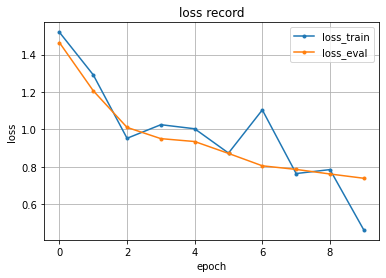

In [21]:
plot_loss(hist)

观察新模型accuracy变化

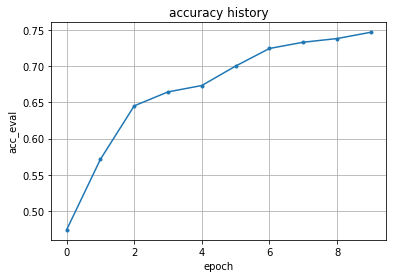

In [22]:
plot_accuracy(hist)

载入最佳网络参数，并测试其accuracy与loss

In [23]:
# 使用准确率最高的参数组合建立模型，并测试其在验证集上的效果
best_param = mindspore.load_checkpoint(os.path.join(ckpt_path, 'best_param.ckpt'), net=network2)
res = model.eval(test_data, dataset_sink_mode=dataset_sink_mode)
print(res)

{'accuracy': 0.747, 'loss': 0.7379924941062928}


## 效果展示

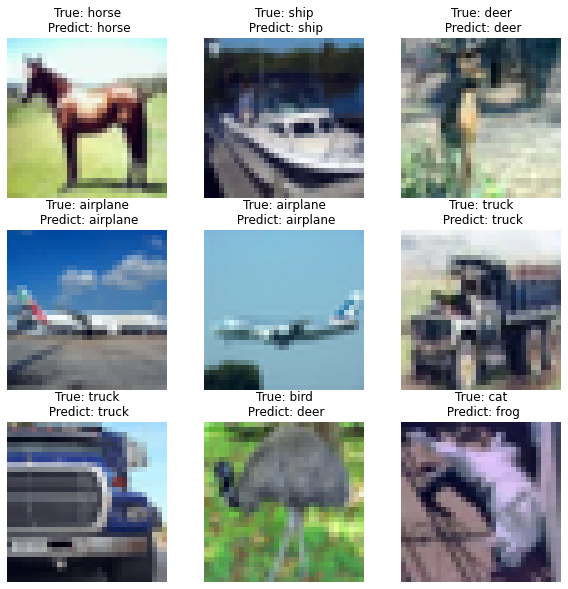

In [24]:
#创建图像标签列表
category_dict = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',
                 6:'frog',7:'horse',8:'ship',9:'truck'}

data_path=os.path.join('data', '10-verify-bin')

demo_data = create_dataset(test_path, batch_size=1, usage='test')

# 将数据标准化至0~1区间
def normalize(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

# 设置图像大小
plt.figure(figsize=(10,10))
i = 1
# 打印9张子图
for dic in demo_data.create_dict_iterator():
    # 预测单张图片
    input_img = dic['image']
    output = model.predict(input_img)
    predict = np.argmax(output.asnumpy(),axis=1)[0] # 反馈可能性最大的类别
    
    # 可视化
    plt.subplot(3,3,i)
    input_image = np.squeeze(input_img.asnumpy(),axis=0) # 删除batch维度，方便可视化
    input_image = input_image.transpose(1,2,0) # CHW转HWC，方便可视化
    input_image = normalize(input_image) # 重新标准化，方便可视化
    plt.imshow(input_image)
    plt.axis('off')
    plt.title('True: %s\n Predict: %s'%(category_dict[dic['label'].asnumpy().item()],category_dict[predict]))
    i +=1
    if i > 9 :
        break

plt.show()

## 思考
1. 为何在数据增强前要加入 if usage == 'train' 的判断式？
    * 答：数据增强的目的是提供模型更多不同的训练数据，评估是不需要做数据增强。
2. 有哪些数据增强的方法（举例）？
    * 答：随机剪裁、随机翻转、随机旋转等
1. 什么是一个step？
    * 答：一个step指一个batch送入网络中完成一次前向计算及反向传播的过程。
2. 编写自定义回调函数需继承什么基类？
    * 答：Callback基类
3. 如何在自定义回调函数中获取训练过程中的重要信息（损失函数、优化器、当前的epoch数等）？
    * 答：通过run_context.original_args()方法可以获取到cb_params字典，字典里会包含训练过程中的重要信息。
1. 本实验的模型欠拟合，可通过增加网络复杂度优化模型。如果模型过拟合，常见的处理方法有哪些？
    * 答：L1，L2正则化，Early stopping，增加数据集，增加噪声，添加dropout层等。
6. 如何理解dataset sink mode？
    * dataset_sink_mode=True时，可以这样简单的理解：Model中仅建立数据通道与执行网络之间的连接关系，不会直接将数据喂给网络。数据会通过数据通道(pipeline)下发到卡上，网络在卡上执行时会直接从对应的数据通道中获取数据。在这种模式下，数据下发与网络执行可以并行，单个epoch的训练过程中host与device之间不会交互，因此能提升性能，也因此打屏以epoch递增。
    * dataset_sink_mode=False，没有使用数据下沉模式。这时候数据不会通过通道直接向Device下发，Model会将数据一个batch一个batch得取出，喂给网络。在这种模式下，每个step结束，host都可以获取device上网络的执行结果，因此打屏以step递增。
7. 为什么本实验的模型在训练集的loss波动较大，且比在测试集高？
    * 答：因为训练集做了数据增强，有些经过剪裁或翻转的图片较难辨认。

## 实验总结
本章提供了一个基于开源框架MindSpore的图像识别实验。该实验演示了如何利用开源框架MindSpore完成CIFAR-10图像识别任务。本章对实验做了详尽的剖析，阐明了整个实验功能、结构与流程，详细解释了如何解析数据、如何构建深度学习模型、如何自定义回调函数以及保存等内容，并且展示了模型的优化与调参。学员可以在该实验的基础上开发更有针对性的应用实验。

## 挑战
本实验的最终模型准确率仍然不高，尝试将模型准确率提升到90%以上